In [24]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [25]:
df = pd.read_csv('creditcard.csv')[:80_000]
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [26]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), Fraud Cases=196'

In [27]:
from sklearn.linear_model import LogisticRegression
# We can increase the weight of each class i.e for non fraud cases 0, we  assign a weight of 1 and for fraud cases 1, we give it double the weight, the idea is that we might have more fraud cases selected\
mod = LogisticRegression(class_weight={0: 1, 1:2}, max_iter=1000)
mod.fit(X, y).predict(X).sum()

171

## We can now find the best value for the class weight using grid search

In [28]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in range(1,4)]},
    cv=4,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [29]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,2.451953,0.437986,0.015982,0.000999,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,2.307646,0.595789,0.009901,0.006451,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99020,0.99840,0.99960,0.99805,0.996563,0.003718,2
2,1.593874,0.110692,0.007809,0.007809,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


## The score comems from our model, we can have the LogisticRegression().score and with lr = LogisticRegression(); ??lr.score we can see the implementation of it

In [30]:
lr = LogisticRegression()
??lr.score

Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for `X`.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
        """
        from .metrics import accuracy_score

        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      c:\users\user\appdata\local\programs\pyth

## We can see that it uses the accuracy_score unless we specify otherwise

In [31]:
from sklearn.metrics import precision_score, recall_score, make_scorer

## precision and recall both measure different things, what recall will tell us is that it will tell us did we get all the fraud cases and precision is saying: given that we predict fraud, how accurate are we

In [32]:
# precision_score(y, grid.predict(X))
recall_score(y, grid.predict(X))

0.5918367346938775

## Now, lets add precision and recall to the grid search: we have to tell the gridsearch to select the best model based on one of  the scores which is the refit property
### Higher cross validation would make our program take longer to run but it would have more accuracy when it comes out
### We can also use a numpy linear space with a dimension to increase the effect of the class weight. And by setting the class weight to a higher value, we are telling the algorithm to focus on the fraud cases

In [33]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
    refit='precision',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 14.758620689655173},
                                          {0: 1, 1: 15.413793103448276},
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='precision', return_train_score=True,
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [34]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,split2_train_recall_score,split3_train_recall_score,split4_train_recall_score,split5_train_recall_score,split6_train_recall_score,split7_train_recall_score,split8_train_recall_score,split9_train_recall_score,mean_train_recall_score,std_train_recall_score
0,3.306898,0.432621,0.026289,0.008036,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",1.000000,0.463415,0.583333,1.000000,...,0.627119,0.548023,0.573864,0.573864,0.562500,0.613636,0.636364,0.607955,0.612185,0.054733
1,3.250074,0.318436,0.014414,0.005319,"{0: 1, 1: 1.6551724137931034}","{'class_weight': {0: 1, 1: 1.6551724137931034}}",1.000000,0.463415,0.583333,1.000000,...,0.683616,0.627119,0.670455,0.647727,0.630682,0.687500,0.698864,0.687500,0.680239,0.050286
2,3.067828,0.309587,0.030181,0.012656,"{0: 1, 1: 2.310344827586207}","{'class_weight': {0: 1, 1: 2.310344827586207}}",1.000000,0.463415,0.583333,1.000000,...,0.740113,0.683616,0.710227,0.698864,0.687500,0.715909,0.744318,0.727273,0.724454,0.043881
3,3.363376,0.379304,0.018469,0.006611,"{0: 1, 1: 2.9655172413793105}","{'class_weight': {0: 1, 1: 2.9655172413793105}}",1.000000,0.452381,0.583333,1.000000,...,0.785311,0.706215,0.744318,0.732955,0.715909,0.755682,0.772727,0.738636,0.749978,0.039589
4,3.140359,0.680013,0.019937,0.004921,"{0: 1, 1: 3.6206896551724137}","{'class_weight': {0: 1, 1: 3.6206896551724137}}",1.000000,0.452381,0.583333,1.000000,...,0.824859,0.740113,0.755682,0.744318,0.727273,0.778409,0.784091,0.761364,0.771498,0.037959
5,3.387144,0.695081,0.024498,0.009948,"{0: 1, 1: 4.275862068965517}","{'class_weight': {0: 1, 1: 4.275862068965517}}",1.000000,0.452381,0.583333,1.000000,...,0.841808,0.768362,0.778409,0.789773,0.772727,0.789773,0.795455,0.772727,0.792485,0.029289
6,3.418090,0.335215,0.025759,0.009812,"{0: 1, 1: 4.931034482758621}","{'class_weight': {0: 1, 1: 4.931034482758621}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.802260,0.789773,0.818182,0.801136,0.801136,0.818182,0.789773,0.812327,0.021063
7,3.388258,0.500178,0.028993,0.011405,"{0: 1, 1: 5.586206896551724}","{'class_weight': {0: 1, 1: 5.586206896551724}}",1.000000,0.452381,0.583333,1.000000,...,0.847458,0.813559,0.829545,0.829545,0.812500,0.806818,0.835227,0.818182,0.827080,0.017190
8,3.403594,0.466811,0.021431,0.007472,"{0: 1, 1: 6.241379310344827}","{'class_weight': {0: 1, 1: 6.241379310344827}}",0.944444,0.452381,0.583333,0.947368,...,0.847458,0.824859,0.846591,0.835227,0.823864,0.829545,0.857955,0.829545,0.838431,0.013974
9,3.283628,0.535721,0.023083,0.009126,"{0: 1, 1: 6.896551724137931}","{'class_weight': {0: 1, 1: 6.896551724137931}}",0.944444,0.452381,0.583333,0.947368,...,0.853107,0.830508,0.846591,0.835227,0.829545,0.835227,0.863636,0.846591,0.844665,0.012015


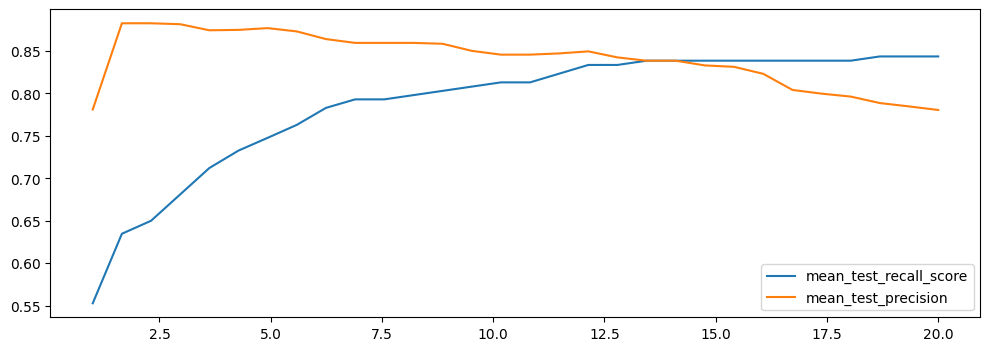

In [35]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision']:
    plt.plot([_[1] for _ in df_results['param_class_weight']],
            df_results[score],
            label=score)
plt.legend();

## We can either go for the  left end where we have the high precision or we go for the right end where we have high recall, or we go for the point where both of them meet

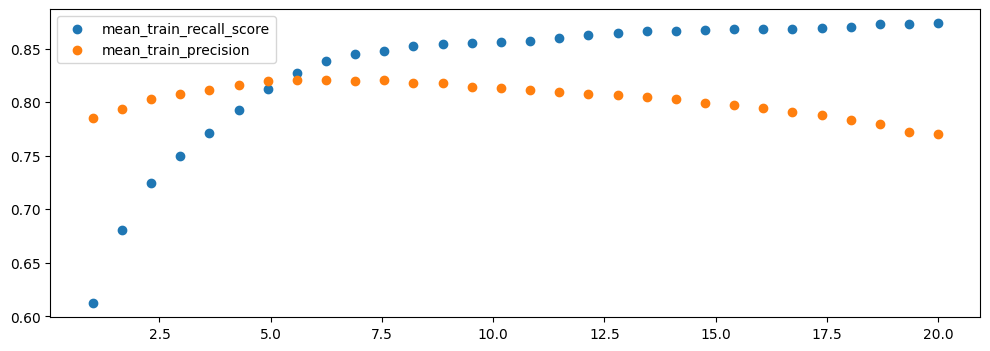

In [36]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall_score', 'mean_train_precision']:
    plt.scatter(x=[_[1] for _ in df_results['param_class_weight']],
               y=df_results[score.replace('test', 'train')],
               label=score)
plt.legend();

## We can use the f1 score to find the balance btw the precision and recall but we can also make our own METRIC to handle that for us

In [37]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

In [38]:
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall_score': make_scorer(recall_score),
            'min_both': make_scorer(min_recall_precision)},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': make_scorer(min_recall_precision),
                      'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

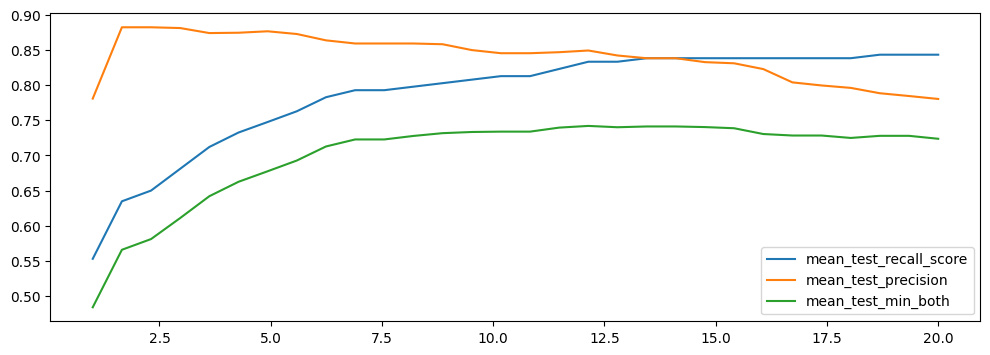

In [39]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']],
            df_results[score],
            label=score)
plt.legend();

In [40]:
jj = make_scorer(min_recall_precision)
??jj

Signature:       jj(estimator, X, y_true, sample_weight=None, **kwargs)
Type:            _PredictScorer
String form:     make_scorer(min_recall_precision)
File:            c:\users\user\appdata\local\programs\python\python310\lib\site-packages\sklearn\metrics\_scorer.py
Source:         
class _PredictScorer(_BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, **kwargs):
        """Evaluate predicted target values for X relative to y_true.

        Parameters
        ----------
        method_caller : callable
            Returns predictions given an estimator, method name, and other
            arguments, potentially caching results.

        estimator : object
            Trained estimator to use for scoring. Must have a `predict`
            method; the output of that is used to compute the score.

        X : {array-like, sparse matrix}
            Test data that will be fed to estimator.predict.

        y_true : array-like
            Gold standard target values

## Looking at the implementation ??, we can see that our make_scorer transformed it into a new function with the estimator etc kargs. We can do this ourselves directly without calling make_scorer

In [41]:
def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall_score': make_scorer(recall_score),
            'min_both': min_recall_precision},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.0},
                                          {0: 1, 1: 1.6551724137931034},
                                          {0: 1, 1: 2.310344827586207},
                                          {0: 1, 1: 2.9655172413793105},
                                          {0: 1, 1: 3.6206896551724137},
                                          {0: 1, 1: 4.275862068965517},
                                          {0: 1, 1: 4.931034482758621},
                                          {0: 1, 1: 5.586206896551724},
                                          {0: 1, 1: 6.241379310344827},
                                          {0: 1, 1: 6.896551724137931},...
                                          {0: 1, 1: 16.06896551724138},
                                          {0: 1, 1: 16.724137931034484},
                                          {0: 1, 1: 17.379310344827587},
                                          {0: 1, 1: 18.03448275862069},
                                          {0: 1, 1: 18.689655172413794},
                                          {0: 1, 1: 19.344827586206897},
                                          {0: 1, 1: 20.0}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': <function min_recall_precision at 0x000001E004A75E10>,
                      'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [64]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']],
            df_results[score],
            label=score)
plt.legend();

KeyError: 'param_class_weight'

<Figure size 1200x400 with 0 Axes>

## The sample weight is that we can tell our machine learning model that a row is more important than the other, it is different from the class weight, for example, if we have a transaction worth millions of dollars and it has fraud in it, it is much more important to catch than a single dollar transaction

In [43]:
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall_score': make_scorer(recall_score),
            'min_both': min_recall_precision},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
# We can take the logarithm of the transactions to prevent overfitting incase we have really big transactions
grid.fit(X, y, sample_weight=np.log(1 + df['Amount']));

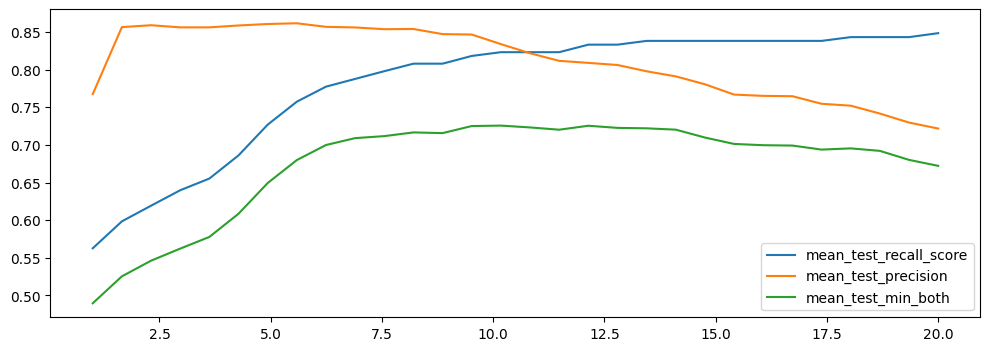

In [44]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']],
            df_results[score],
            label=score)
plt.legend();

## We can treat fraud as an outlier, so instead of logistic regression, we can use an outlier detector

In [53]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
# Counter(mod.predict(X))
# If we want to translate this outlier detection, we can change it from 0 if we have no fraud and 1 if there is a fraud
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

## THe contamination factor has the Hyperparameter that we want to tune

In [54]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator = IsolationForest(),
    param_grid = {'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision,
            'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)
grid.fit(X, y)

GridSearchCV(cv=5, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': array([0.001     , 0.00311111, 0.00522222, 0.00733333, 0.00944444,
       0.01155556, 0.01366667, 0.01577778, 0.01788889, 0.02      ])},
             refit='precision',
             scoring={'precision': <function outlier_precision at 0x000001E00490EC20>,
                      'recall': <function outlier_recall at 0x000001E00490C5E0>})

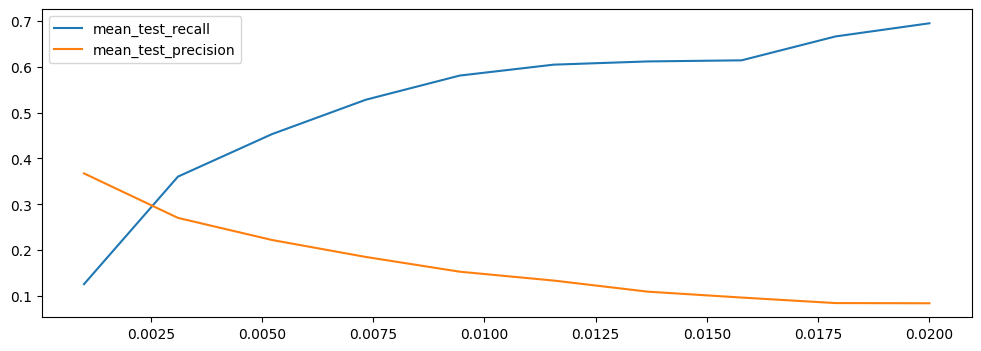

In [58]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'],
            df_results[score],
            label=score)
plt.legend();b

## We can use other args in our make_scorer function, we can set the needs_proba and the greater_is_better if we would need that or not, then we pass it into our grid search

In [65]:
make_scorr(min_recall_precision, greater_is_better=False)
?make_scorer

Signature:
make_scorer(
    score_func,
    *,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    **kwargs,
)
Docstring:
Make a scorer from a performance metric or loss function.

This factory function wraps scoring functions for use in
:class:`~sklearn.model_selection.GridSearchCV` and
:func:`~sklearn.model_selection.cross_val_score`.
It takes a score function, such as :func:`~sklearn.metrics.accuracy_score`,
:func:`~sklearn.metrics.mean_squared_error`,
:func:`~sklearn.metrics.adjusted_rand_score` or
:func:`~sklearn.metrics.average_precision_score`
and returns a callable that scores an estimator's output.
The signature of the call is `(estimator, X, y)` where `estimator`
is the model to be evaluated, `X` is the data and `y` is the
ground truth labeling (or `None` in the case of unsupervised models).

Read more in the :ref:`User Guide <scoring>`.

Parameters
----------
score_func : callable
    Score function (or loss function) with signature
    ``score_